<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/NN%20CNN%20LSTM%20EEG%20DF%20MI%20Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> R. Leeb, F. Lee, C. Keinrath, R. Scherer, H. Bischof, G. Pfurtscheller. Brain-computer communication: motivation, aim, and impact of ex- ploring a virtual apartment. IEEE Transactions on Neural Systems and Rehabilitation Engineering 15, 473–482, 2007.

The cue-based screening paradigm consisted of two classes, namely the motor imagery (MI) of left hand (class 1) and right hand (class 2).


The subjects were right-handed, had normal or corrected-to-normal vision and were paid for participating in the experiments. All volunteers were sitting in an armchair, watching a flat screen monitor placed approximately 1 m away at eye level. For each subject 5 sessions are provided, whereby the first two sessions contain training data without feedback (screening), and the last three sessions were recorded with feedback.


Three bipolar recordings (C3, Cz, and C4) were recorded with a sampling frequency of 250 Hz. The recordings had a dynamic range of ±100 μV for the screening and ±50 μV for the feedback sessions. They were bandpass-filtered between 0.5 Hz and 100 Hz, and a notch filter at 50 Hz was enabled. The electrode position Fz served as EEG ground.


Sessions #9 - for train model has an index "T" (train) = MI-EEG-B9T.csv
Sessions #9 - for test model has an index "E" (evaluate)= MI-EEG-B9E.csv


исходный датасет:
https://www.physionet.org/content/eegmmidb/1.0.0/S001/#files-panel


источник данных:
https://www.bbci.de/competition/iv/

статья:
https://www.sciencedirect.com/science/article/pii/S0957417418305359?via%3Dihub

##CNN-2D и CNN-2D + LSTM + STFT + CWT

In [ ]:
!pip install pywavelets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 62.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
import pywt
import cv2
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                          TimeDistributed, LSTM)
from keras.optimizers import Adam
from keras import backend as K

In [ ]:
# download dataset
x_train = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/MI-EEG-B9T.csv?raw=true",
                      header=None)
x_test = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/MI-EEG-B9E.csv?raw=true",
                     header=None)
y_train = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/2class_MI_EEG_train_9.csv?raw=true",
                      header=None)
y_test = pd.read_csv("https://github.com/TAUforPython/BioMedAI/blob/main/test_datasets/2class_MI_EEG_test_9.csv?raw=true",
                     header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 3000)
(320, 3000)
(400, 1)
(320, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 400
n_samples_test : 320


In [ ]:
# count classes
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [ ]:
# calculate STFT

def spectrogram_vertical(data, fs, alto, ancho, n_canales, pts_sig,
                                 pts_superpuestos):
  #fs = fs #frecuencia de muestreo
  datesets = np.zeros((data.shape[0],alto, ancho))

  # crear matriz 2D donde se guardara cada imagen del STFT
  temporal = np.zeros((alto, ancho))

  for i in range(data.shape[0]): # n muestras
    for j in range(n_canales): # n canales

      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]

      f, t, Sxx = spectrogram(sig, fs=fs, window='hann', nperseg=fs,
                              noverlap=pts_superpuestos, nfft=fs*2,
                              scaling='spectrum')

      # concatenacion vertical chanels
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]

    datesets[i] = temporal
    if i % 100 == 0:
      print(i)
  return datesets

In [ ]:
# calculate scalogram CWT

def scalogram_vertical(data, fs, alto, ancho, n_canales, pts_sig):
  dim = (int(np.floor(ancho/2)), int(np.floor(alto/2))) # ancho, alto

  # Wavelet Morlet 3-3
  # frequency 8 - 30 Hz
  scales = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)

  datesets = np.zeros((data.shape[0], int(np.floor(alto/2)),
                    int(np.floor(ancho/2))))

  temporal = np.zeros((alto, ancho))

  for i in range(data.shape[0]):
    for j in range(n_canales):

      sig = data.iloc[i, j*pts_sig:(j+1)*pts_sig]

      coef, freqs = pywt.cwt(sig, scales, 'cmor3-3',
                             sampling_period = (1 / fs))

      temporal[j*45:(j+1)*45, :] = abs(coef)

    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datesets[i] = resized
    if i % 100 == 0:
      print(i)
  return datesets

In [ ]:
initial = time.time()

# STFT
x_train = spectrogram_vertical(x_train, 250, 135, 31, 3, 1000, 225)
x_test = spectrogram_vertical(x_test, 250, 135, 31, 3, 1000, 225)

# CWT
#x_train = scalogram_vertical(x_train, 250, 135, 1000, 3, 1000)
#x_test = scalogram_vertical(x_test, 250, 135, 1000, 3, 1000)

fin = time.time()
print("time_elapsed:", fin - initial)

0
100
200
300
0
100
200
300
time_elapsed: 1.48185396194458


In [ ]:
print(x_train.shape)
print(x_test.shape)

(400, 135, 31)
(320, 135, 31)


In [ ]:
x = np.ceil(np.max(x_train))

In [ ]:
# convert to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= x
x_test /= x

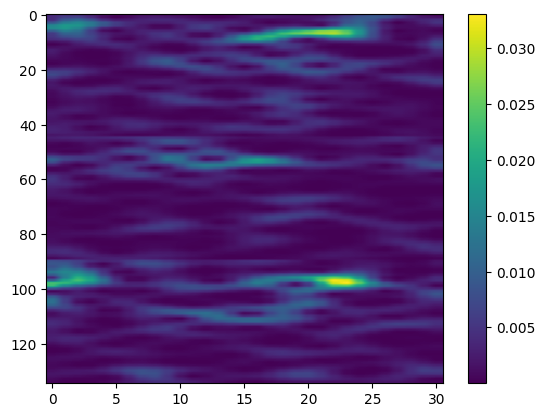

In [ ]:
plt.figure()
plt.imshow(x_train[1],  aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
#  reshape a 4D (for CNN-2D)
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# convert  3D to 5D (CNN-2D + LSTM)
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(400, 1, 135, 31, 1)
(320, 1, 135, 31, 1)


In [ ]:
# crear red neuronal CNN-2D

def CNN_2D(num_filter, size_filter, n_neurons):
  model = Sequential()
  model.add(Conv2D(num_filter, size_filter, activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(num_filter, size_filter, activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(learning_rate=0.001)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
# crear red neuronal CNN-2D + LSTM

def CNN_2D_LSTM_TD(num_filter, size_filter, n_neurons, units_LSTM):
  model = Sequential()
  model.add(TimeDistributed(Conv2D(num_filter, size_filter, activation='relu',
                                   padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(num_filter, size_filter, activation='relu',
                                   padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units_LSTM, activation='tanh', dropout=0.5))
  model.add(Dense(n_neurons, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(learning_rate=1e-3)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
initial = time.time()
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)


  #model = CNN_2D(4, (3,3), 32)
  model = CNN_2D_LSTM_TD(4, (3,3), 32, 4)

 # history = model.fit(x_train, y_train, epochs=40, batch_size=36,
 #                     validation_data=(x_test, y_test), verbose=0)

  history = model.fit(x_train, y_train, epochs=70, batch_size=36,
                       validation_split = 0.1, verbose=0)

  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)

Iteration: 1
loss:  0.48261937499046326
accuracy:  0.7875000238418579
Iteration: 2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.4847906529903412
accuracy:  0.762499988079071
Iteration: 3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.45975661277770996
accuracy:  0.7875000238418579
Iteration: 4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.45312756299972534
accuracy:  0.78125
Iteration: 5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


loss:  0.48100337386131287
accuracy:  0.765625


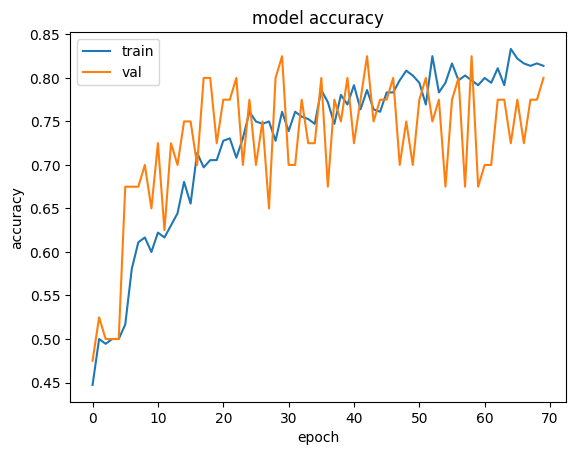

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
probabilidades = model.predict(x_test)

y_pred = np.argmax(probabilidades, 1)

  # calculate kappa cohen
kappa = cohen_kappa_score(y_test, y_pred)
array_kappa.append(kappa)
print("kappa: ", kappa)
matriz_confusion = confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", matriz_confusion)


#Интерпретация
#(\kappa = 1): Полное согласие, модель идеально предсказывает все классы.
#(\kappa = 0): Согласие на уровне случайного угадывания.
#(\kappa < 0): Согласие хуже, чем случайное угадывание.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
kappa:  0.6125
confusion matrix:
 [[132  28]
 [ 34 126]]


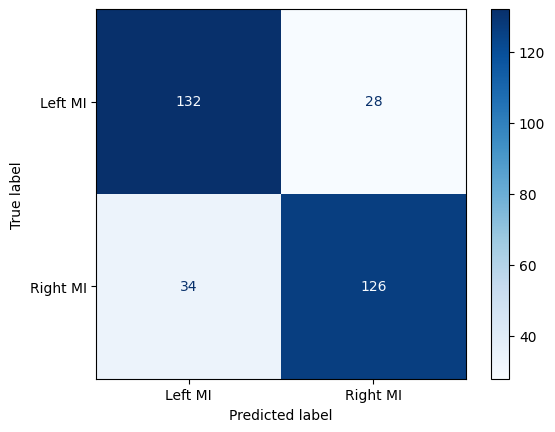

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["Left MI", "Right MI"]

disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

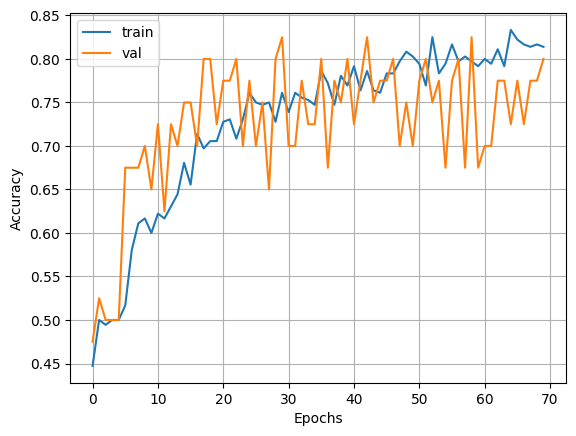

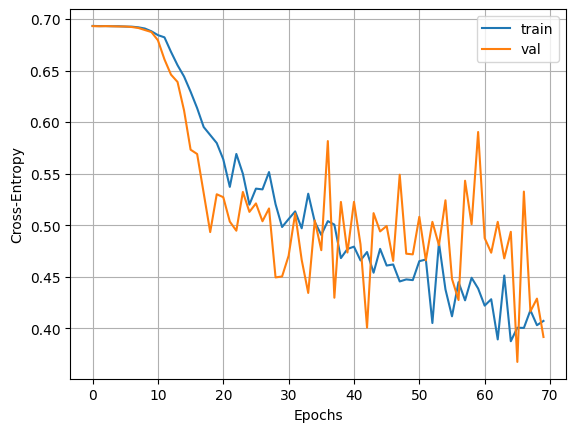


Resultados:
loss: [0.48261937499046326, 0.4847906529903412, 0.45975661277770996, 0.45312756299972534, 0.48100337386131287]
accuracy: [0.7875000238418579, 0.762499988079071, 0.7875000238418579, 0.78125, 0.765625]
kappa: [0.6125]
time_elapsed: 122.4216821193695


In [ ]:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'val'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'val'])
  plt.show()

print()
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
time_elapsed = fin - initial
print("time_elapsed:", time_elapsed)

In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_21                  │ (None, 1, 135, 31, 4)       │              40 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 1, 67, 15, 4)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 1, 67, 15, 4)        │             148 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 1, 33, 7, 4)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 1, 924)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 4)                   │          14,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,836 (179.05 KB)

 Trainable params: 15,278 (59.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,558 (119.37 KB)

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("time_elapsed:", int(time_elapsed))

Mean Accuracy: 0.7875
std: (+/- 0.0163)
Mean Kappa: 0.5563
std: (+/- 0.0000)
Max Accuracy: 0.8188
Max Kappa: 0.5563
time_elapsed: 109
